In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

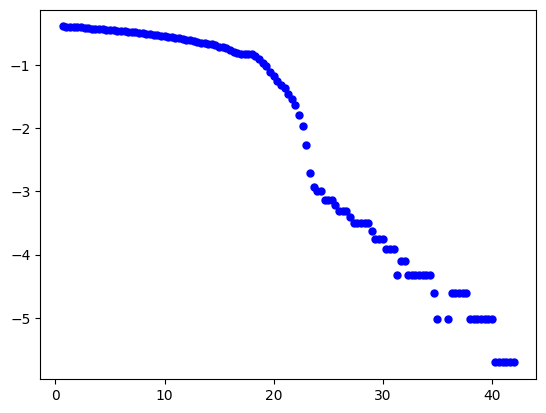

(123, 3)


In [3]:
data = pd.read_csv("/Users/ypm/Desktop/DoS/data/autoSlope.csv")
# data = data[(data['Times'] >= 200) & (data['Times'] <= 300)]
plt.plot(data['Times'], data['Width'], 'bo', markersize=5)
plt.show()
print(data.shape)

128


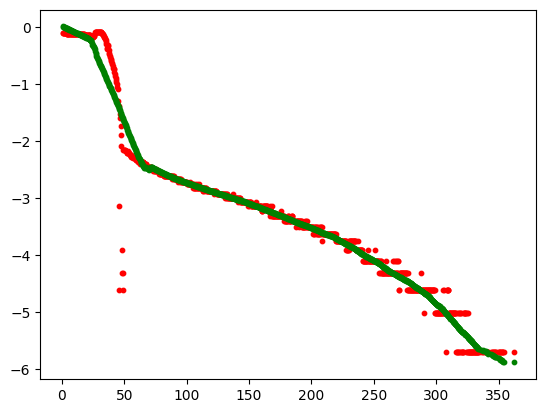

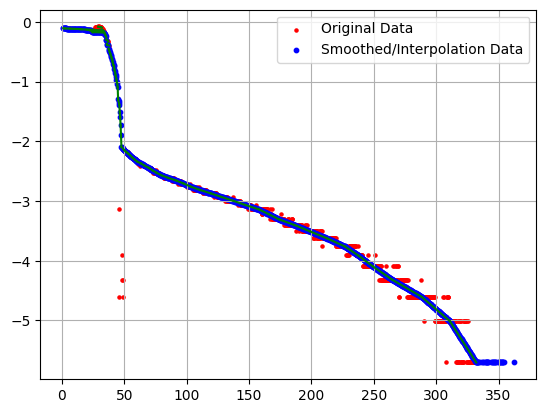

,Times,Width
0,0.666889,-0.109071
1,1.000333,-0.105361
2,1.375458,-0.106288
3,1.750584,-0.107216
4,2.125709,-0.108143
...,...,...
1022,352.784261,-5.703782
1023,353.117706,-5.703782
1024,353.451150,-5.703782
1025,354.118039,-5.703782


In [122]:
def linspaceSmoother(df):
    processed_df = df.copy()
    df['Diff'] = df['Width'].diff()
    step_centers = df.groupby('Width')['Times'].median().tolist()
    plt.scatter(df['Times'], df['Width'], label='Original Data', s=5, color="red")
    # plt.vlines(step_centers, ymin=df['Width'].min(), ymax=df['Width'].max(), color='grey', label='Step Centers')
    step_widths = []
    step_centers = step_centers[::-1]
    for center in step_centers:
        width = df[df['Times'] == center]['Width'].values
        if len(width) == 0:
            nearest_width = df.iloc[(df['Times'] - center).abs().argsort()[:1]]['Width'].values
            if len(nearest_width) > 0: 
                step_widths.append(nearest_width[0])
        else:
            step_widths.append(width[0])
    for i in range(len(step_widths) - 1):
        df_for_x = df[(df['Times'] >= step_centers[i]) & (df['Times'] <= step_centers[i + 1])]
        count_x = len(df_for_x)
        x_vals = np.linspace(step_centers[i], step_centers[i + 1], num=count_x)
        y_vals = np.linspace(step_widths[i], step_widths[i + 1], num=count_x)
        processed_df.loc[df_for_x.index, 'Times'] = x_vals
        processed_df.loc[df_for_x.index, 'Width'] = y_vals
        plt.plot(x_vals, y_vals, color='green')
    plt.scatter(processed_df['Times'], processed_df['Width'], label='Smoothed/Interpolation Data', s=10, color="blue")
    plt.legend()
    plt.grid()
    plt.show()
    processed_df = processed_df[["Times", "Width"]]
    processed_df = processed_df.dropna()
    return  processed_df

def savGolSmoother(dataframe, window_length=15, polyorder=1):
    times = dataframe["Times"].values
    width = dataframe["Width"].values
    window_length = len(width)//8
    print(window_length)
    smoothed_width = savgol_filter(width, window_length, polyorder)
    smoothed_df = pd.DataFrame({"Times": times, "Width": smoothed_width})
    return smoothed_df

sm_data = savGolSmoother(data)
plt.scatter(data["Times"], data["Width"], color="red", s=10)
plt.scatter(sm_data["Times"], sm_data["Width"], color="green", s=10)
plt.show()

linspaceSmoother(data)


128
[-0.04200949636957981, -0.008037456165964359, -0.008530418747058108, -0.012941219982175801, -0.02020340150612289, -0.0010050966500548225]
Orig - [-0.04200949636957981, -0.008037456165964359, -0.008530418747058108, -0.012941219982175801, -0.02020340150612289, -0.0010050966500548225] 

Filtered - [-0.04200949636957981, -0.008037456165964359, -0.008530418747058108, -0.012941219982175801, -0.02020340150612289, -0.0010050966500548225] 

Processed - [-0.008037456165964359, -0.008530418747058108] 

Slope - -0.008283937456511233 


(<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/pyplot.py'>,
 -0.008283937456511233)

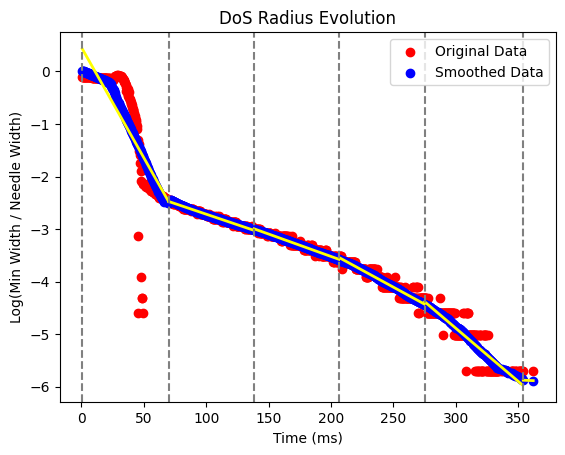

In [133]:
def find_appropriate_slope(lst):
    print("Orig -",lst, "\n")
    lst = list(filter(lambda x: x < 0, lst))
    print("Filtered -", lst, "\n")
    slope = []  
    for i in range(len(lst) - 1):
        ratio = lst[i] / lst[i+1]  
        diff = max(lst[i], lst[i+1]) - min(lst[i], lst[i+1])
        if 1.1 >= ratio >= 0.9:
            slope.append(lst[i])  
            slope.append(lst[i+1])  
    print("Processed -", slope, "\n")
    print("Slope -", sum(slope) / len(slope), "\n")
    return sum(slope) / len(slope)


def autoRegressor(orig_data):
    smoothed_data = savGolSmoother(orig_data)
    x = smoothed_data["Times"]
    y = smoothed_data["Width"]
    slopes = []
    intercepts = []
    window_size = len(x) // 5
    for section_start in range(0, len(x), window_size):
        end = section_start + window_size
        group_x = x[section_start:end].values.reshape(-1, 1)
        group_y = y[section_start:end]
        lr = LinearRegression()
        lr.fit(group_x, group_y)
        y_pred = lr.predict(group_x)
        slopes.append(lr.coef_[0])
        intercepts.append(lr.intercept_)
        plt.plot(group_x, y_pred, color='yellow', linewidth=2)
        plt.axvline(x=group_x[0], color='grey', linestyle='--')
    plt.scatter(orig_data["Times"], orig_data["Width"], label="Original Data", color="red")
    plt.scatter(smoothed_data["Times"], smoothed_data["Width"], label="Smoothed Data", color="blue")
    plt.legend()
    plt.xlabel("Time (ms)")
    plt.ylabel("Log(Min Width / Needle Width)")
    plt.title("DoS Radius Evolution")
    print(slopes)

    return plt, find_appropriate_slope(slopes)

autoRegressor(data)

,Width,Times,Diff
0,-0.395515,0.666889,NaN
1,-0.397996,0.833611,-0.004963
2,-0.398823,1.000333,-0.002481
3,-0.400484,1.167056,-0.003317
4,-0.402483,1.333778,-0.003741
...,...,...,...
118,-4.854338,37.345782,-0.069315
119,-4.923653,37.712571,-0.069315
120,-4.992968,38.079360,-0.069315
121,-5.062283,38.446149,-0.069315


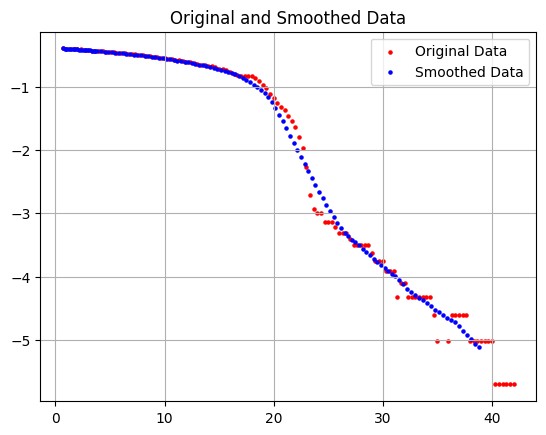

In [99]:
def average(dataframe, window_size=20):
    smoothed_data = dataframe.rolling(window=window_size, min_periods=1).mean()

    plt.scatter(dataframe["Times"], dataframe["Width"], label='Original Data', s=5, c='red')
    plt.scatter(smoothed_data["Times"], smoothed_data["Width"], label=f'Smoothed Data', s=5, c="blue")
    plt.legend()
    plt.title('Original and Smoothed Data')
    plt.grid(True)
    return smoothed_data

average(data)